In [7]:
import sys
sys.path.append('../../')

In [224]:
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import jraph

from models.gnn import GNN
from models.segnn import SEGNN
from models.utils.graph_utils import build_graph

import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [91]:
n_nodes = 5000
n_features = 6

x_train = np.load("../../../hierarchical-encdec/data/set_diffuser_data/train_halos.npy")[:, :n_nodes, :n_features]
x_train = x_train / 1000.

# Conver to jnp
x_train = jnp.array(x_train)

x_train.shape

(1800, 5000, 6)

Node prediction task -- randomly knock out 10% of the velocities, and try to predict them.

In [305]:
import e3nn_jax as e3nn
from models.utils.equivariant_graph_utils import get_equivariant_graph
from models.utils.graph_utils import build_graph
from models.utils.irreps_utils import weight_balanced_irreps
from models.segnn import SEGNN
from models.utils.graph_utils import get_apply_pbc

class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):        
        return jax.vmap(GNN(task="node", d_output=3))(x)
    
class GraphWrapper(nn.Module):

    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
            velocities = None
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
            velocities = e3nn.IrrepsArray("1o", x.nodes[..., 3:6])

        # print(nodes)
        
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=velocities,
            steerable_velocities=True,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=1,
            apply_pbc=None
        )
        
        return jax.vmap(SEGNN(task="node", output_irreps="1x1o", num_blocks=2))(st_graph)

In [306]:
graph = build_graph(
    halos=x_train[:2, :, :],
    tpcfs=None,
    k=20,
    use_edges=True,
)

In [307]:
model = GraphWrapper()

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)
sum(x.size for x in jax.tree_util.tree_leaves(params))

50012

In [308]:
print(out.nodes.shape)

(2, 5000, 3)


In [309]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [310]:
# Define train state and replicate across devices
tx = optax.adamw(learning_rate=6e-4, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [311]:
def loss_mse(pred_batch, halo_batch, mask):
    # Only compute MSE based on mask (values which are 1)
    if isinstance(pred_batch, e3nn.IrrepsArray):
        pred_batch = pred_batch.array  # Euclidean distance is preserved by MSE, so we are safe doing this

    return jnp.sum(jnp.where(mask, (pred_batch - halo_batch[..., 3:6]) ** 2, 0.))

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch_masked, halo_batch, mask):

    # Set those velocities in x_batch (only indices 3:6 of last dimension of x_batch) to 0
    halo_graph = build_graph(halo_batch_masked, 
                None, 
                k=20, 
    )

    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs.nodes, halo_batch, mask)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [312]:
n_steps = 1000
n_batch = 32
n_train = 1800 

key = jax.random.PRNGKey(0)

train_loss_segnn = []

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x_train.shape[0], shape=(n_batch,))

        x_batch = x_train[idx]

        # Get a mask of shape (n_batch, n_nodes) to randomly mask out velocities of 10% of the halos.
        mask = jax.random.bernoulli(jax.random.PRNGKey(42), 0.1, shape=(n_batch, n_nodes, 1))

        # # Set those velocities in x_batch (indices 3:6 of last dimension) to shuffled
        # x_batch = x_batch.at[:, :, 3:6].set(jnp.where(mask, jax.random.permutation(subkey, x_batch[:, :, 3:6], axis=-2), x_batch[:, :, 3:6]))
        
        # Set those velocities in x_batch (indices 3:6 of last dimension) to 0
        x_batch_masked = x_batch.at[:, :, 3:6].set(jnp.where(mask, -2.0, x_batch[:, :, 3:6]))

        # Split batches across devices
        x_batch_masked = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), x_batch_masked)
        x_batch_masked = jnp.array(x_batch_masked)

        x_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), x_batch)
        x_batch = jnp.array(x_batch)

        mask = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), mask)
        mask = jnp.array(mask)

        pstate, metrics = train_step(pstate, x_batch_masked, x_batch, mask)

        loss = unreplicate(metrics["loss"])
        train_loss_segnn.append(loss)
        
        steps.set_postfix(loss=loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:47<00:00,  5.99it/s, loss=494.11798]


Text(0.5, 1.0, 'Predict 10% missing velocities')

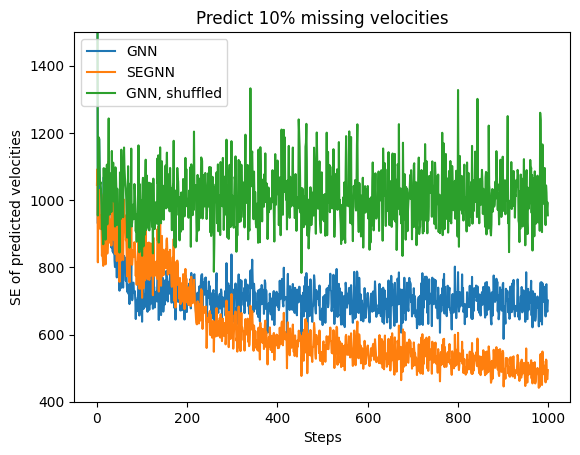

In [313]:
import matplotlib.pyplot as plt

plt.plot(train_loss_gnn, label="GNN")
plt.plot(train_loss_segnn, label="SEGNN")
plt.plot(train_loss_gnn_shuffled, label="GNN, shuffled")

plt.legend()
plt.ylim(400, 1500)
plt.xlabel("Steps")
plt.ylabel("SE of predicted velocities")

plt.title("Predict 10% missing velocities")